## Train

In [1]:
%%capture
!pip install datasets evaluate transformers[sentencepiece]
!pip install rouge_score
!pip install transformers[torch]
!pip install csv
!pip install pandas
!pip install scikit-learn

In [2]:
# !gsutil cp -r gs://vietai_public/viT5/data/vietnews .
# !gsutil cp -r gs://vietai_public/viT5/data/wikilingua .


In [3]:
from google.colab import drive
drive.mount('/colabDrive')
# filePath="/colabDrive/MyDrive/colabDrive/hyperSmallDataset.csv"

Mounted at /colabDrive


In [4]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, TrainingArguments, Seq2SeqTrainingArguments
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import csv

In [5]:
%%capture
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("/colabDrive/MyDrive/colabDrive/ModelStep2")
model.to('cuda')

In [6]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["inputs"], max_length=512, truncation=True, padding=True
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["labels"], max_length=512, truncation=True, padding=True
        )
    model_inputs['labels'] = labels['input_ids']
    model_inputs['input_ids'] = model_inputs['input_ids']
    return model_inputs

In [7]:
# Deprecated
# input_lines = []
# label_lines = []

# train_file = '/colabDrive/MyDrive/colabDrive/miniDataset.csv'

# with open(f'{train_file}', newline='') as file:
#     reader = csv.reader(file)
#     for line in reader:
#         input_lines.append(line[0] +'</s>')
#         label_lines.append(line[1])

# dict_obj = {'inputs': input_lines, 'labels': label_lines}
# dataset = Dataset.from_dict(dict_obj)
# tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)

In [8]:
# input_lines

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
train_file = '/colabDrive/MyDrive/colabDrive/output_file_3.csv'
# Read the CSV file using pandas
df = pd.read_csv(train_file)

# Assuming `dataset` is your original dataset
train_dataset, eval_dataset = train_test_split(df, test_size=0.2)

def prepareDataset(df):
    # Convert the columns to lists
    input_lines = df['AccentlessSentences'].tolist()
    label_lines = df['Sentences'].tolist()

    # Append '</s>' to each input line
    input_lines = [line + '</s>' for line in input_lines]

    dict_obj = {'inputs': input_lines, 'labels': label_lines}
    dataset = Dataset.from_dict(dict_obj)
    tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)
    return tokenized_datasets

tokenized_training_datasets=prepareDataset(train_dataset)
tokenized_eval_datasets=prepareDataset(eval_dataset)


Map (num_proc=8):   0%|          | 0/20000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map (num_proc=8):   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [10]:
tokenized_eval_datasets

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5000
})

In [11]:

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

training_args = Seq2SeqTrainingArguments("tmp/",
                                      do_train=True,
                                      do_eval=True,
                                      num_train_epochs=2,
                                      learning_rate=1e-5,
                                      warmup_ratio=0.05,
                                      weight_decay=0.01,
                                      per_device_train_batch_size=5,
                                      per_device_eval_batch_size=5,
                                      logging_dir='./log',
                                      group_by_length=True,
                                      save_strategy="steps",
                                      save_steps=500,
                                      save_total_limit=3,
                                      evaluation_strategy="steps",
                                      eval_steps=500,
                                      logging_strategy="steps",
                                      logging_steps=500,
                                      fp16=True,
                                      )


# training_args = Seq2SeqTrainingArguments("tmp/",
#                                       do_train=True,
#                                       do_eval=True,
#                                       num_train_epochs=2,
#                                       learning_rate=1e-5,
#                                       warmup_ratio=0.05,
#                                       weight_decay=0.01,
#                                       per_device_train_batch_size=5,
#                                       per_device_eval_batch_size=5,
#                                       logging_dir='./log',
#                                       group_by_length=True,
#                                       save_strategy="epoch",
#                                       save_total_limit=3,
#                                       evaluation_strategy="epoch",
#                                       logging_strategy="epoch",
#                                       fp16=True,
#                                       )



# AdaFactor for ViT5-large models as it based on T5v1.1.
# See https://medium.com/the-artificial-impostor/paper-adafactor-adaptive-learning-rates-with-sublinear-memory-cost-a543abffa37
#
# from transformers.optimization import Adafactor, AdafactorSchedule
# optimizer = Adafactor(
#     model.parameters(),
#     lr=1e-3,
#     eps=(1e-30, 1e-3),
#     clip_threshold=1.0,
#     decay_rate=-0.8,
#     beta1=None,
#     weight_decay=0.0,
#     relative_step=False,
#     scale_parameter=False,
#     warmup_init=False
# )
# lr_scheduler = AdafactorSchedule(optimizer)


In [12]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_training_datasets,
    eval_dataset=tokenized_eval_datasets,
    data_collator=data_collator,
)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,0.020200,0.012554
1000,0.018900,0.011773
1500,0.017900,0.011171
2000,0.017200,0.010797
2500,0.016700,0.010158
3000,0.015400,0.009830
3500,0.015000,0.009558
4000,0.014800,0.009496
4500,0.010700,0.009318
5000,0.011100,0.009100


TrainOutput(global_step=8000, training_loss=0.013792769312858581, metrics={'train_runtime': 5575.2394, 'train_samples_per_second': 7.175, 'train_steps_per_second': 1.435, 'total_flos': 1.42823282851584e+16, 'train_loss': 0.013792769312858581, 'epoch': 2.0})

In [13]:

# After training, you can evaluate the model like this:
metrics = trainer.evaluate()

print(metrics)

{'eval_loss': 0.00847549643367529, 'eval_runtime': 109.127, 'eval_samples_per_second': 45.818, 'eval_steps_per_second': 9.164, 'epoch': 2.0}


In [14]:

# Save the model
trainer.save_model('/colabDrive/MyDrive/colabDrive/ModelStep3')
#tokenizer.save_pretrained("/colabDrive/MyDrive/colabDrive/myTokenizer")

In [15]:
trainer.state.log_history

[{'loss': 0.0202,
  'learning_rate': 9.868421052631579e-06,
  'epoch': 0.12,
  'step': 500},
 {'eval_loss': 0.012554170563817024,
  'eval_runtime': 108.2673,
  'eval_samples_per_second': 46.182,
  'eval_steps_per_second': 9.236,
  'epoch': 0.12,
  'step': 500},
 {'loss': 0.0189,
  'learning_rate': 9.210526315789474e-06,
  'epoch': 0.25,
  'step': 1000},
 {'eval_loss': 0.011772562749683857,
  'eval_runtime': 108.7072,
  'eval_samples_per_second': 45.995,
  'eval_steps_per_second': 9.199,
  'epoch': 0.25,
  'step': 1000},
 {'loss': 0.0179,
  'learning_rate': 8.552631578947368e-06,
  'epoch': 0.38,
  'step': 1500},
 {'eval_loss': 0.01117127574980259,
  'eval_runtime': 108.9246,
  'eval_samples_per_second': 45.903,
  'eval_steps_per_second': 9.181,
  'epoch': 0.38,
  'step': 1500},
 {'loss': 0.0172,
  'learning_rate': 7.894736842105265e-06,
  'epoch': 0.5,
  'step': 2000},
 {'eval_loss': 0.010796570219099522,
  'eval_runtime': 108.8586,
  'eval_samples_per_second': 45.931,
  'eval_steps_pe

In [16]:
import json

with open("/colabDrive/MyDrive/colabDrive/log_history3.json", "w") as f:
    json.dump(trainer.state.log_history, f)


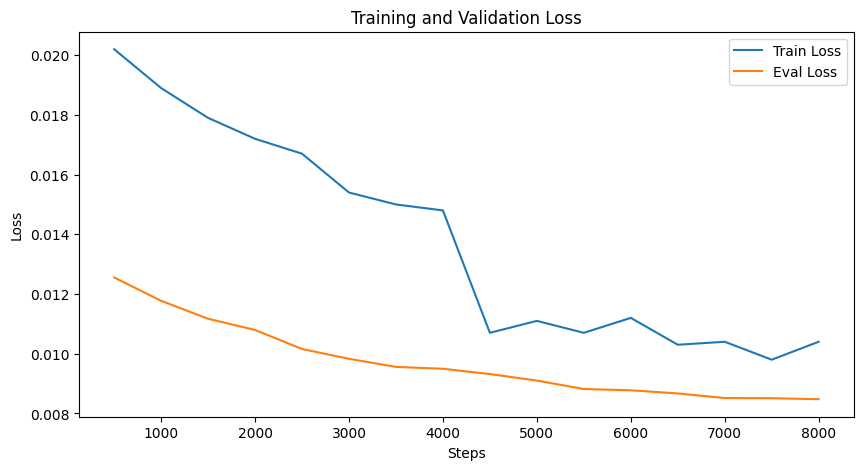

In [17]:
# Draw a graph

import matplotlib.pyplot as plt

# Assuming that 'history' is your training history
def plot_graphs(history):
    # Extract values from the history
    # accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
    train_loss = [x['loss'] for x in history if 'loss' in x]
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

    # Extract step values
    steps = [x['step'] for x in history if ('loss' in x or 'eval_loss' in x)]
    # Remove duplicates and preserve order
    steps = list(dict.fromkeys(steps))
    # print(steps[:-1])
    # Plot the losses
    plt.figure(figsize=(10,5))
    plt.plot(steps, train_loss, label='Train Loss')
    plt.plot(steps, eval_loss[:-1] , label='Eval Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()



# Call the function
plot_graphs(trainer.state.log_history)

## Inference

In [ ]:
from datasets import load_metric
metric = load_metric("rouge")


<ipython-input-18-ffe5587f2e49>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


In [ ]:
import pandas as pd
train_file = '/colabDrive/MyDrive/colabDrive/output_file_3.csv'
# Read the CSV file using pandas
df = pd.read_csv(train_file)

# Convert the columns to lists
input_lines = df['AccentlessSentences'].tolist()
label_lines = df['Sentences'].tolist()

# Append '</s>' to each input line
input_lines = [line + '</s>' for line in input_lines]

dict_obj = {'inputs': input_lines, 'labels': label_lines}
dataset = Dataset.from_dict(dict_obj)
test_tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=10)

# input_lines = []
# label_lines = []
# with open(f'{task}/test.tsv') as file:
#   for line in file:
#     line = line.strip().split('\t')
#     input = line[0]
#     input_lines.append(input +'</s>')
#     label_lines.append(line[1])



# input_lines  = input_lines
# label_lines = label_lines
# dict_obj = {'inputs': input_lines, 'labels': label_lines}

# dataset = Dataset.from_dict(dict_obj)
# test_tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=10)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

Map (num_proc=10):   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained('/colabDrive/MyDrive/colabDrive/ModelStep2')
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model.to('cuda')

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
import torch
import numpy as np
metrics = load_metric('rouge')

max_target_length = 512
dataloader = torch.utils.data.DataLoader(test_tokenized_datasets, collate_fn=data_collator, batch_size=32)

predictions = []
references = []
for i, batch in enumerate(tqdm(dataloader)):
  outputs = model.generate(
      input_ids=batch['input_ids'].to('cuda'),
      max_length=max_target_length,
      attention_mask=batch['attention_mask'].to('cuda'),
  )
  with tokenizer.as_target_tokenizer():
    outputs = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in outputs]

    labels = np.where(batch['labels'] != -100,  batch['labels'], tokenizer.pad_token_id)
    actuals = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in labels]
  predictions.extend(outputs)
  references.extend(actuals)
  metrics.add_batch(predictions=outputs, references=actuals)


metrics.compute()


  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3848: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'rouge1': AggregateScore(low=Score(precision=0.9854877566983564, recall=0.9835821239131501, fmeasure=0.9842603134842383), mid=Score(precision=0.9865787982512315, recall=0.9846776849375947, fmeasure=0.9853398679592354), high=Score(precision=0.9875615716542246, recall=0.9856957089644232, fmeasure=0.9863664292263224)),
 'rouge2': AggregateScore(low=Score(precision=0.9759781030960829, recall=0.9740555665523303, fmeasure=0.9747342258392588), mid=Score(precision=0.9775228701518739, recall=0.9756070490296598, fmeasure=0.976268153467351), high=Score(precision=0.9789938974518383, recall=0.9771370182456085, fmeasure=0.9777739265715516)),
 'rougeL': AggregateScore(low=Score(precision=0.9849116791317372, recall=0.9829943027670317, fmeasure=0.9837228358631727), mid=Score(precision=0.9859692754947532, recall=0.9840393590413885, fmeasure=0.9847332741213857), high=Score(precision=0.9870097093232816, recall=0.9851792869775379, fmeasure=0.9858460710129059)),
 'rougeLsum': AggregateScore(low=Score(preci

In [ ]:
[{k: v.mid.fmeasure} for k,v in metrics.compute(predictions=predictions, references=references).items()]


[{'rouge1': 0.9853398679592354},
 {'rouge2': 0.976268153467351},
 {'rougeL': 0.9847332741213857},
 {'rougeLsum': 0.9847534603939524}]